In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import math
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
plt.rcParams['font.sans-serif'] = ['SimHei']   #设置简黑字体
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data=pd.read_csv("LoanStats3a.csv",encoding="ANSI")

B:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,25,32,34,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,0.0,0.00,0,15-Jan,171.62,NaN,15-Jan,0.0,NaN,1.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,0.0,117.08,1.11,13-Apr,119.66,NaN,13-Sep,0.0,NaN,1.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,0.0,0.00,0,14-Jun,649.91,NaN,15-Apr,0.0,NaN,1.0


B:\anaconda\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
B:\anaconda\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 5585., 10690.,  8713.,  5371.,  4400.,  3343.,  1295.,  1846.,
          493.,   799.]),
 array([  500.,  3950.,  7400., 10850., 14300., 17750., 21200., 24650.,
        28100., 31550., 35000.]),
 <a list of 10 Patch objects>)

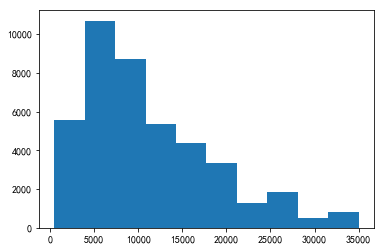

In [4]:
plt.hist(data.loan_amnt)

In [5]:
data1=data.iloc[:,[2,7,8]]

In [6]:
#增加一列loan_zmnt的分组
X_dot = list(np.arange(0,35001,5000))

In [7]:
X_group = pd.DataFrame(pd.cut(data1.loan_amnt,bins=X_dot,right=True,retbins=False,include_lowest=False))

In [8]:
data1['loan_gr'] = X_group

B:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
data1.head(3)

,loan_amnt,installment,grade,loan_gr
0,5000.0,162.87,B,"(0.0, 5000.0]"
1,2500.0,59.83,C,"(0.0, 5000.0]"
2,2400.0,84.33,C,"(0.0, 5000.0]"


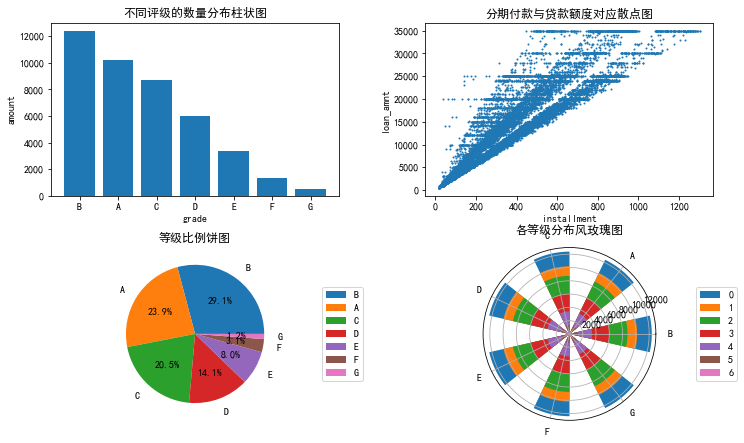

In [10]:
#柱状图
grade=pd.DataFrame(data1['grade'].value_counts()).reset_index()
plt.figure(figsize=(10,6))
plt.subplots_adjust(left=0.04, top= 0.96, right = 0.96, bottom = 0.04, wspace = 0.3, hspace = 0.3)
plt.subplot(221)
plt.bar(grade['index'],grade['grade'])
plt.xlabel('grade')
plt.ylabel('amount')
plt.title('不同评级的数量分布柱状图')
#散点图
plt.subplot(222)
plt.scatter(data1.installment,data1.loan_amnt,s=1)
plt.xlabel('installment')
plt.ylabel('loan_amnt')
plt.title('分期付款与贷款额度对应散点图')
#饼图
plt.subplot(223)
label = data1.grade.value_counts().index
plt.pie(data1.grade.value_counts(),labels=label,autopct = '%3.1f%%',labeldistance=1.2)
plt.legend(loc=4, bbox_to_anchor=(1.5,0.2))
plt.title('等级比例饼图')
#风玫瑰图
N = 7# 风速分布为7个方向
theta = np.linspace(0, 2*np.pi, N, endpoint=False) # 获取7个方向的角度值
width = np.pi / N  # 绘制扇型的宽度，可以自行调整
labels = list(grade['index']) # 自定义坐标标签
ax = plt.subplot(224, projection='polar')
for idx in grade.index:
    # 每一行绘制一个扇形
    radii = grade.loc[idx][1] # 每一行数据
    ax.bar(theta, radii, width=width, bottom=0.0, label=idx, tick_label=labels)
plt.title('各等级分布风玫瑰图')
plt.legend(loc=4, bbox_to_anchor=(1.5, 0.2)) # 将label显示出来， 并调整位置


B:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(250, 8500, '此处密度最大')

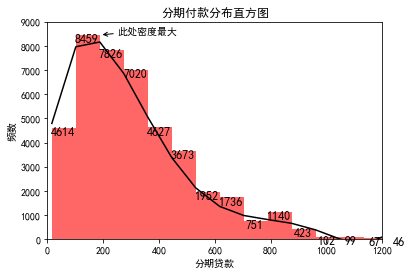

In [11]:
#连续型变量的分布直方图
n, bins, patches=plt.hist(data1.installment,normed=False,color="r",bins=15,alpha=0.6)
plt.xlabel('分期贷款')
plt.ylabel('频数')
plt.title('分期付款分布直方图') 
#用多项式拟合
f1 = np.polyfit(bins[:-1], n, 5)
p1 = np.poly1d(f1)
yvals = p1(bins)#拟合y值
plt.plot(bins, yvals, 'black',label='polyfit values')
for a,b in zip(bins,n):
    plt.text(a+40, b-400, '%.0f' % b, ha='center', va= 'bottom',fontsize=12)
plt.ylim(0,9000)    
plt.xlim(0,1200)   
plt.annotate("此处密度最大", (190,8459),xytext=(250,8500),arrowprops=dict(arrowstyle='->')) 

B:\anaconda\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
B:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


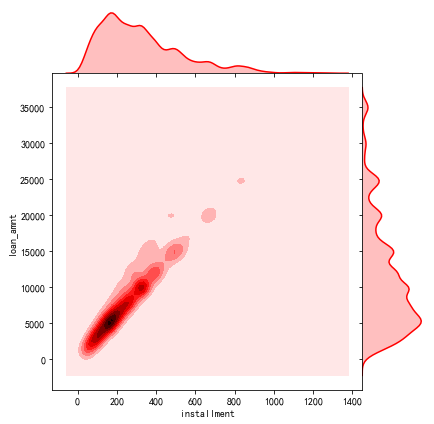

In [12]:
#两个连续型变量的密度图
sns.jointplot(x=data1.installment, y=data1.loan_amnt, kind='kde', color="r",space=0,size=6)

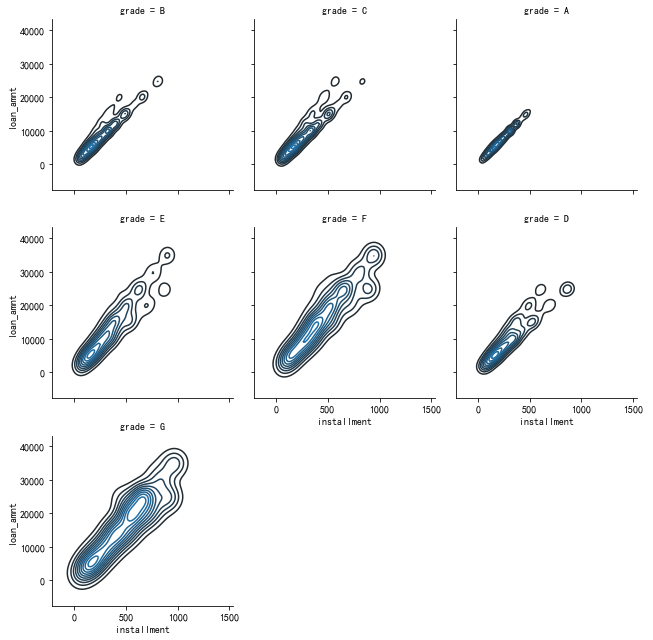

In [13]:
#分箱化的密度图
g2 = sns.FacetGrid(data1,  col="grade",col_wrap=3)
g2 = (g2.map(sns.kdeplot,"installment","loan_amnt")).add_legend()

In [14]:
#聚类准备
pd.set_option('display.max_columns', None)
data.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,VERIFIED - income,11-Dec,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.70%,9,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0,15-Jan,171.62,NaN,15-Jan,0.0,NaN,1.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,VERIFIED - income source,11-Dec,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.40%,4,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,13-Apr,119.66,NaN,13-Sep,0.0,NaN,1.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,not verified,11-Dec,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0,1-Nov,2.0,NaN,NaN,2.0,0.0,2956,98.50%,10,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0,14-Jun,649.91,NaN,15-Apr,0.0,NaN,1.0


In [15]:
data11 = data.iloc[:1000,[2,7,13,38,39,40]]

In [16]:
data11

,loan_amnt,installment,annual_inc,total_pymnt,total_pymnt_inv,total_rec_prncp
0,5000.0,162.87,24000.0,5861.071414,5831.78,5000.00
1,2500.0,59.83,30000.0,1008.710000,1008.71,456.46
2,2400.0,84.33,12252.0,3003.653644,3003.65,2400.00
3,10000.0,339.31,49200.0,12226.302210,12226.30,10000.00
4,3000.0,67.79,80000.0,2632.060000,2632.06,1722.67
...,...,...,...,...,...,...
995,2425.0,84.39,80004.0,3052.790000,3052.79,2424.99
996,6950.0,223.97,43000.0,7349.480000,7349.48,6950.01
997,12375.0,398.79,32000.0,13433.960000,13399.63,12375.01
998,35000.0,933.14,85000.0,37299.600000,34607.03,19266.24


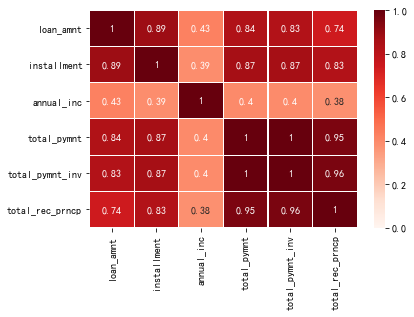

In [17]:
correlations = data11.corr()
correction=abs(correlations)# 取绝对值，只看相关程度 ，不关心正相关还是负相关
# plot correlation matrix
ax = sns.heatmap(correction,cmap=plt.cm.Reds, linewidths=0.05,vmax=1, vmin=0 ,annot=True,annot_kws={'size':10,'weight':'bold'})

In [18]:
#上图可见相关度较高，为聚类后便于显示，将其降维
#标准化
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
st = StandardScaler().fit_transform(data11)
df = pd.DataFrame(st)
df.columns = data11.columns
#变量方差占比
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(df)
pca.explained_variance_ratio_

array([0.78825745, 0.13218929, 0.05468883])

In [19]:
0.78825745+ 0.13218929

0.92044674

In [20]:
# 进行降维,降到2维
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df)
# 查看降维后的数据
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
principalDf.head(5)

,principal component 1,principal component 2
0,-2.237496,-0.718552
1,-3.397696,-0.224359
2,-3.127574,-0.883998
3,-0.349544,-0.363649
4,-2.722062,1.205744


Text(0, 0.5, '第二主成分')

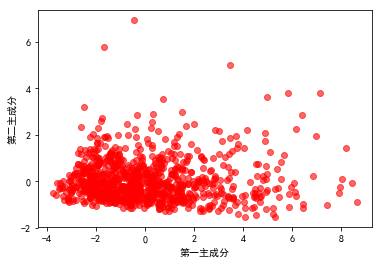

In [21]:
plt.scatter(principalDf.iloc[:, 0],principalDf.iloc[:, 1], c = "red", marker='o', label='see',alpha=0.6)
plt.xlabel('第一主成分')
plt.ylabel('第二主成分')

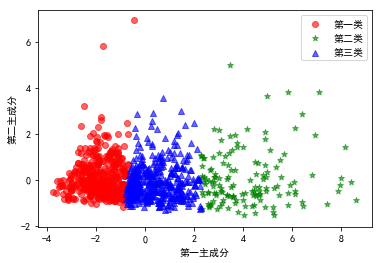

In [22]:
estimator = KMeans(n_clusters=3)#构造聚类器
estimator.fit(principalDf)#构造聚类器
label_pred = estimator.labels_ #获取聚类标签
#绘制k-means结果
x0 = principalDf[label_pred == 0]
x1 = principalDf[label_pred == 1]
x2 = principalDf[label_pred == 2]
plt.scatter(x0.iloc[:, 0], x0.iloc[:, 1], c = "red", marker='o', label='第一类',alpha=0.6)
plt.scatter(x1.iloc[:, 0], x1.iloc[:, 1], c = "green", marker='*', label='第二类',alpha=0.6)
plt.scatter(x2.iloc[:, 0], x2.iloc[:, 1], c = "blue", marker='^', label='第三类',alpha=0.6)
plt.xlabel('第一主成分')
plt.ylabel('第二主成分')
plt.legend(loc=1)


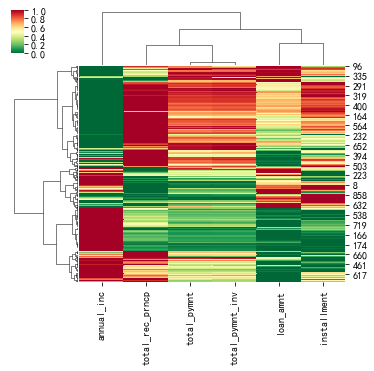

In [23]:
#因为各变量量纲不同，所以此处没有使用原始数据集，而改用标准化后的数据集画热图
sns.clustermap(df,method ='ward',metric='euclidean',figsize=(6,5),cmap='RdYlGn_r',standard_scale = 0)